In [116]:
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import pathlib
import os
import json
import math
import re

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# Setup paths
current_directory_path = pathlib.Path("/content/drive/MyDrive/422001503103_Nhom9_NhanDienChuVietTayTiengViet/source_code/data2").absolute()
DATA_PATH = os.path.join(str(current_directory_path), "data")
RAW_FOLDER = os.path.join(str(current_directory_path), "Image")
TRAIN_JSON = os.path.join(str(current_directory_path), "labels.json")

# Load labels
with open(TRAIN_JSON, 'r', encoding='utf8') as f:
    train_labels = json.load(f)

# Map image paths to labels
dict_filepath_label = {}
raw_data_path = pathlib.Path(RAW_FOLDER)
for item in raw_data_path.glob('**/*.*'):
    file_name = str(os.path.basename(item))
    if file_name in train_labels:
        dict_filepath_label[str(item)] = train_labels[file_name]

In [119]:
# Build character vocabulary
char_list = sorted(set(''.join(train_labels.values())))

def encode_to_labels(txt):
    """Encode text to character indices"""
    return [char_list.index(char) for char in txt if char in char_list]

# Model hyperparameters
TIME_STEPS = 240
resize_max_width = 2167
max_label_len = TIME_STEPS
batch_size = 32

In [120]:
class ImageDataGenerator(Sequence):
    """Data generator for Vietnamese handwriting recognition"""
    
    def __init__(self, image_paths, labels_dict, char_list, max_label_len, 
                 TIME_STEPS, batch_size, resize_max_width, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = image_paths
        self.labels_dict = labels_dict
        self.char_list = char_list
        self.max_label_len = max_label_len
        self.TIME_STEPS = TIME_STEPS
        self.batch_size = batch_size
        self.resize_max_width = resize_max_width
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.image_paths) / self.batch_size)
    
    def _preprocess_image(self, img_path):
        """Preprocess single image"""
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize to fixed height maintaining aspect ratio
        height, width = img.shape
        if height != 118:
            img = cv2.resize(img, (int(118 / height * width), 118))
        
        # Pad to fixed width
        height, width = img.shape
        img = np.pad(img, ((0, 0), (0, self.resize_max_width - width)), 'median')
        
        # Apply filters
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 11, 4)
        
        # Normalize
        img = np.expand_dims(img, axis=2) / 255.0
        return img

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        batch_labels_text = [self.labels_dict[path] for path in batch_image_paths]

        batch_images = [self._preprocess_image(path) for path in batch_image_paths]
        batch_encoded_labels = [encode_to_labels(label) for label in batch_labels_text]
        batch_label_lengths = [len(label) for label in batch_encoded_labels]

        batch_images = np.array(batch_images)
        batch_input_length = np.full((len(batch_image_paths), 1), self.TIME_STEPS, dtype=np.int64)
        batch_label_lengths = np.array(batch_label_lengths).reshape(-1, 1)
        batch_padded_labels = pad_sequences(batch_encoded_labels, maxlen=self.max_label_len, 
                                            padding='post', value=0)

        return ((batch_images, batch_padded_labels, batch_input_length, batch_label_lengths), 
                np.zeros(len(batch_image_paths)))

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [ ]:
# Split data
all_image_paths = list(dict_filepath_label.keys())
train_image_paths, val_image_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)

# Create data generators
generator_params = {
    'labels_dict': dict_filepath_label,
    'char_list': char_list,
    'max_label_len': max_label_len,
    'TIME_STEPS': TIME_STEPS,
    'batch_size': batch_size,
    'resize_max_width': resize_max_width
}

training_batch_generator = ImageDataGenerator(image_paths=train_image_paths, **generator_params)
validation_batch_generator = ImageDataGenerator(image_paths=val_image_paths, **generator_params)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [121]:
# Build CRNN model
inputs = Input(shape=(118, 2167, 1))

# CNN feature extraction
x = Conv2D(64, (3,3), padding='same')(inputs)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)
x_1 = x

x = Conv2D(128, (3,3), padding='same')(x)
x = MaxPool2D(pool_size=3, strides=3)(x)
x = Activation('relu')(x)

x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_3 = x

# Residual block 1
x = Conv2D(256, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, x_3])
x = Activation('relu')(x)
x_4 = x

x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_5 = x

# Residual block 2
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, x_5])
x = Activation('relu')(x)

x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 1))(x)
x = Activation('relu')(x)

x = MaxPool2D(pool_size=(3, 1))(x)

# Reshape for RNN
squeezed = Lambda(lambda x: K.squeeze(x, 1))(x)

# Bidirectional LSTM layers
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.2))(blstm_1)

# Output layer
outputs = Dense(len(char_list) + 1, activation='softmax')(blstm_2)

act_model = Model(inputs, outputs)

In [ ]:
# CTC loss configuration
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# Training model
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

In [ ]:
class MetricsCallback(Callback):
    """Custom callback for OCR metrics evaluation"""
    
    def __init__(self, model_to_predict, validation_generator, char_list_decoder, ocr_metrics_func):
        super().__init__()
        self.model_to_predict = model_to_predict
        self.validation_generator = validation_generator
        self.char_list_decoder = char_list_decoder
        self.ocr_metrics_func = ocr_metrics_func
        self.epoch_logs = {'val_cer': [], 'val_wer': [], 'val_ser': []}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\nEvaluating metrics at end of epoch {epoch+1}...")

        # Get validation batch
        (valid_img_batch, _, _, _), _ = self.validation_generator[0]
        
        batch_indices = self.validation_generator.indices[:self.validation_generator.batch_size]
        batch_image_paths = [self.validation_generator.image_paths[i] for i in batch_indices]
        valid_orig_txt_batch = [self.validation_generator.labels_dict[path] for path in batch_image_paths]

        # Predict
        prediction = self.model_to_predict.predict(valid_img_batch, verbose=0)
        input_length_pred = np.ones(prediction.shape[0]) * prediction.shape[1]
        out = K.get_value(K.ctc_decode(prediction, input_length=input_length_pred, greedy=True)[0][0])

        # Decode predictions
        predicted_texts = []
        for x in out:
            pred = ''.join([self.char_list_decoder[int(p)] for p in x if int(p) != -1])
            predicted_texts.append(pred)

        # Calculate metrics
        avg_cer, avg_wer, avg_ser = self.ocr_metrics_func(
            predicts=predicted_texts,
            ground_truth=valid_orig_txt_batch,
            norm_accentuation=False,
            norm_punctuation=False
        )

        # Update logs
        logs['val_cer'] = avg_cer
        logs['val_wer'] = avg_wer
        logs['val_ser'] = avg_ser
        
        for key in self.epoch_logs:
            self.epoch_logs[key].append(logs[key])

        print(f"Epoch {epoch+1}: val_cer={avg_cer:.4f}, val_wer={avg_wer:.4f}, val_ser={avg_ser:.4f}")

In [122]:
def levenshtein_distance(s1, s2):
    """Calculate Levenshtein distance (character level)"""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def levenshtein_distance_word_level(words1, words2):
    """Calculate Levenshtein distance (word level)"""
    if len(words1) < len(words2):
        return levenshtein_distance_word_level(words2, words1)
    if len(words2) == 0:
        return len(words1)

    previous_row = range(len(words2) + 1)
    for i, w1 in enumerate(words1):
        current_row = [i + 1]
        for j, w2 in enumerate(words2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (w1 != w2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def normalize_vietnamese_text(text, norm_accentuation=False, norm_punctuation=False):
    """Normalize Vietnamese text"""
    text = text.lower()
    
    if norm_punctuation:
        text = re.sub(r'[^\w\s]', '', text)
    
    if norm_accentuation:
        vietnamese_accents = {
            'á': 'a', 'à': 'a', 'ả': 'a', 'ạ': 'a', 'ã': 'a',
            'ă': 'a', 'ắ': 'a', 'ằ': 'a', 'ẳ': 'a', 'ặ': 'a', 'ẵ': 'a',
            'â': 'a', 'ấ': 'a', 'ầ': 'a', 'ẩ': 'a', 'ậ': 'a', 'ẫ': 'a',
            'đ': 'd',
            'é': 'e', 'è': 'e', 'ẻ': 'e', 'ẹ': 'e', 'ẽ': 'e',
            'ê': 'e', 'ế': 'e', 'ề': 'e', 'ể': 'e', 'ệ': 'e', 'ễ': 'e',
            'í': 'i', 'ì': 'i', 'ỉ': 'i', 'ị': 'i', 'ĩ': 'i',
            'ó': 'o', 'ò': 'o', 'ỏ': 'o', 'ọ': 'o', 'õ': 'o',
            'ô': 'o', 'ố': 'o', 'ồ': 'o', 'ổ': 'o', 'ộ': 'o', 'ỗ': 'o',
            'ơ': 'o', 'ớ': 'o', 'ờ': 'o', 'ở': 'o', 'ợ': 'o', 'ỡ': 'o',
            'ú': 'u', 'ù': 'u', 'ủ': 'u', 'ụ': 'u', 'ũ': 'u',
            'ư': 'u', 'ứ': 'u', 'ừ': 'u', 'ử': 'u', 'ự': 'u', 'ữ': 'u',
            'ý': 'y', 'ỳ': 'y', 'ỷ': 'y', 'ỵ': 'y', 'ỹ': 'y'
        }
        for accented, base in vietnamese_accents.items():
            text = text.replace(accented, base)
    
    return text.strip()

def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate CER, WER, and SER metrics"""
    total_cer = total_wer = total_ser = 0
    num_samples = len(predicts)
    
    if num_samples == 0:
        return 0, 0, 0

    for gt, pred in zip(ground_truth, predicts):
        gt_normalized = normalize_vietnamese_text(gt, norm_accentuation, norm_punctuation)
        pred_normalized = normalize_vietnamese_text(pred, norm_accentuation, norm_punctuation)

        # Character Error Rate
        char_dist = levenshtein_distance(gt_normalized, pred_normalized)
        if len(gt_normalized) > 0:
            total_cer += char_dist / len(gt_normalized)
        elif char_dist > 0:
            total_cer += 1.0

        # Word Error Rate
        gt_words = gt_normalized.split()
        pred_words = pred_normalized.split()
        word_dist = levenshtein_distance_word_level(gt_words, pred_words)
        if len(gt_words) > 0:
            total_wer += word_dist / len(gt_words)
        elif word_dist > 0:
            total_wer += 1.0

        # Sequence Error Rate
        if gt_normalized != pred_normalized:
            total_ser += 1

    return total_cer / num_samples, total_wer / num_samples, total_ser / num_samples

In [ ]:
# Setup callbacks
metrics_callback = MetricsCallback(
    model_to_predict=act_model,
    validation_generator=validation_batch_generator,
    char_list_decoder=char_list,
    ocr_metrics_func=ocr_metrics
)

callbacks_list = [
    TensorBoard(
        log_dir='./logs',
        histogram_freq=10,
        profile_batch=0,
        write_graph=True,
        write_images=False,
        update_freq="epoch"
    ),
    ModelCheckpoint(
        filepath=os.path.join('model_checkpoint_weights.weights.h5'),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        min_delta=1e-8,
        factor=0.2,
        patience=10,
        verbose=1
    ),
    metrics_callback
]

In [ ]:
# Train model
epochs = 100
history = model.fit(
    x=training_batch_generator,
    epochs=epochs,
    validation_data=validation_batch_generator,
    verbose=1,
    callbacks=callbacks_list
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

  return {key: serialize_keras_object(value) for key, value in obj.items()}


Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 332.8588
Epoch 1: val_loss improved from inf to 259.79428, saving model to model_checkpoint_weights.weights.h5

Đang đánh giá các chỉ số vào cuối epoch 1...
Epoch 1: val_cer=0.9872, val_wer=0.9872, val_ser=1.0000
61/61 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - loss: 331.6707 - val_loss: 259.7943 - learning_rate: 0.0010 - val_cer: 0.9872 - val_wer: 0.9872 - val_ser: 1.0000
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 215.3094
Epoch 2: val_loss improved from 259.79428 to 226.94147, saving model to model_checkpoint_weights.weights.h5

Đang đánh giá các chỉ số vào cuối epoch 2...
Epoch 2: val_cer=0.7492, val_wer=0.7492, val_ser=1.0000
61/61 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 215.1951 - val_loss: 226.9415 - learning_rate: 0.0010 - val_cer: 0.7492 - val_wer: 0.7492 - val_ser: 1.0000
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 180.9201
Epoch 3: val_loss improved from 226.94147 to 207.77951, saving model to m

In [131]:
# Load best model weights
act_model.load_weights('/content/drive/MyDrive/422001503103_Nhom9_NhanDienChuVietTayTiengViet/source_code/model_checkpoint_weights.hdf5')

In [132]:
# Get validation batch
(valid_img, valid_labels, valid_input_length, valid_label_length), _ = validation_batch_generator[0]

# Get ground truth labels
batch_indices = validation_batch_generator.indices[:validation_batch_generator.batch_size]
batch_image_paths = [validation_batch_generator.image_paths[i] for i in batch_indices]
valid_orig_txt = [validation_batch_generator.labels_dict[path] for path in batch_image_paths]

In [ ]:
# Prepare validation data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [ ]:
# Predict on validation set
prediction = act_model.predict(valid_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step


In [ ]:
prediction.shape

(32, 240, 141)

In [ ]:
# Decode CTC predictions
out = K.get_value(K.ctc_decode(
    prediction, 
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True
)[0][0])

# Display results
all_predictions = []
for i, x in enumerate(out):
    print(f"Ground truth:  {valid_orig_txt[i]}")
    pred = ''.join([char_list[int(p)] for p in x if int(p) != -1])
    print(f"Predicted:     {pred}\n")
    all_predictions.append(pred)

original_text  =  22 Linh Trung, Phường Linh Trung, Quận Thủ Đức, TP Hồ Chí Minh
predicted text = 22 Linh Trung, Phường Linh Trung, Quận Thủ Đức, TP Hồ Chí Minh
original_text  =  Tổ 30 khu 3, Phường Quán Toan, Quận Hồng Bàng, Hải Phòng
predicted text = Tổ 30 khu 3, Phường Quán Toan, Quận Hồng Bàng, Hải Phòng
original_text  =  860/26/10 Huỳnh Tấn Phát, Phường Tân Phú, Quận 7, TP Hồ Chí Minh
predicted text = 860/26/10 Huỳnh Tấn Phát, Phường Tân Phú, Quận 7, TP Hồ Chí Minh
original_text  =  9 Điện Biên Phủ, phường Minh Khai, quận Hồng Bàng, Hải Phòng
predicted text = 9 Điện Siền Phản, ghường Minh Khai, Quận gyềng Bìng, Hải Phòng
original_text  =  Khóm 7, Thị trấn Định An, Huyện Trà Cú, Trà Vinh
predicted text = Khóm 7, Thị trấn Định An, Huyện Trà Cú, Trà Vinh
original_text  =  Thôn Phúc Lộc, Xã Châu Phong, Huyện Quế Võ, Bắc Ninh
predicted text = Thôn Phúc Lộc, xã Châu Phon, Huyện Quế V0, Bắc Ninh
original_text  =  ấp 2, Xã Bàu Cạn, Huyện Long Thành, Đồng Nai
predicted text = ấp 2, Xã Bàu 

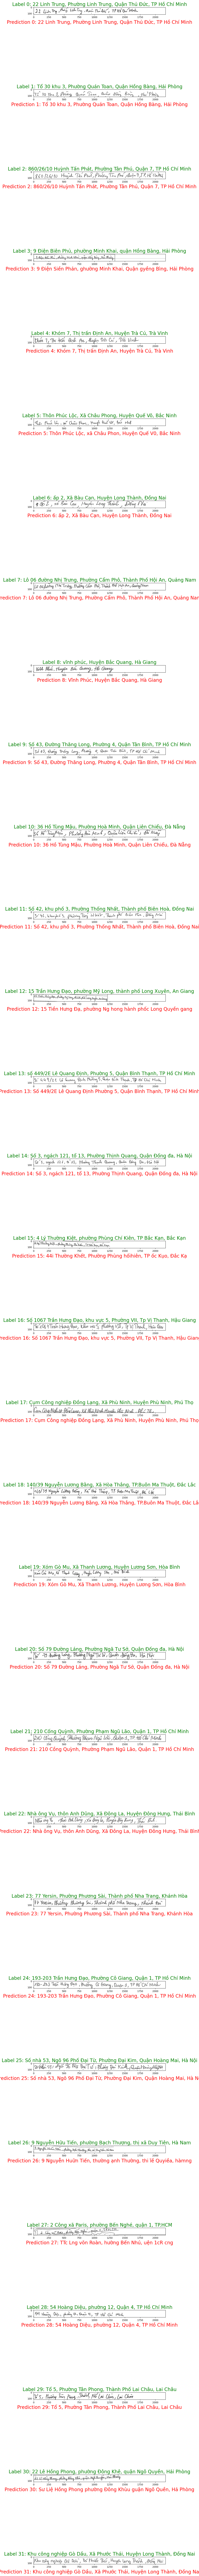

In [ ]:
# Visualize predictions
NO_PREDICTS = len(valid_img)
plt.figure(figsize=(10, 200))
gs1 = gridspec.GridSpec(NO_PREDICTS, 1)

for n in range(NO_PREDICTS):
    plt.subplot(gs1[n])
    plt.imshow(valid_img[n][:, :, 0], cmap="gray_r")
    plt.title(f"Label: {valid_orig_txt[n]}", fontsize=20, color="green")
    plt.xlabel(f"Prediction: {all_predictions[n]}", fontsize=20, color="red")

In [ ]:
# Evaluate OCR metrics
cer, wer, ser = ocr_metrics(
    predicts=all_predictions,
    ground_truth=valid_orig_txt,
    norm_accentuation=False,
    norm_punctuation=False
)

print("Metrics:")
print(f"Character Error Rate: {cer}")
print(f"Word Error Rate:      {wer}")
print(f"Sequence Error Rate:  {ser}")

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# CER curve
axes[1].plot(history.history['val_cer'], label='Validation CER', color='red')
axes[1].set_title('Character Error Rate')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('CER')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

In [123]:
def preprocess_single_image(image_path, resize_max_width=2167):
    """Preprocess a single image for prediction"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Cannot read image from: {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize maintaining aspect ratio
    height, width = img.shape
    if height != 118:
        img = cv2.resize(img, (int(118 / height * width), 118))
    
    # Pad to fixed width
    height, width = img.shape
    img = np.pad(img, ((0, 0), (0, resize_max_width - width)), 'median')
    
    # Apply filters
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 11, 4)
    
    # Normalize and add dimensions
    img = np.expand_dims(img, axis=2) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_single_image(model, image_path, char_list, resize_max_width=2167):
    """Predict text from a single image"""
    processed_image = preprocess_single_image(image_path, resize_max_width)
    
    # Predict
    prediction = model.predict(processed_image, verbose=0)
    input_length = np.ones(prediction.shape[0]) * prediction.shape[1]
    decoded = K.get_value(K.ctc_decode(prediction, input_length=input_length, greedy=True)[0][0])
    
    # Decode to text
    predicted_text = ''.join([char_list[int(p)] for p in decoded[0] if int(p) != -1])
    return predicted_text, processed_image[0]

print("Image preprocessing and prediction functions ready!")

Đã định nghĩa các hàm tiền xử lý và nhận diện ảnh!


✓ Tìm thấy ảnh: /content/drive/MyDrive/422001503103_Nhom9_NhanDienChuVietTayTiengViet/source_code/test3.png

KẾT QUẢ NHẬN DIỆN:
Văn bản: 9 Điện Siền Phản, ghường Minh Khai, Quận gyềng Bìng, Hải Phòng


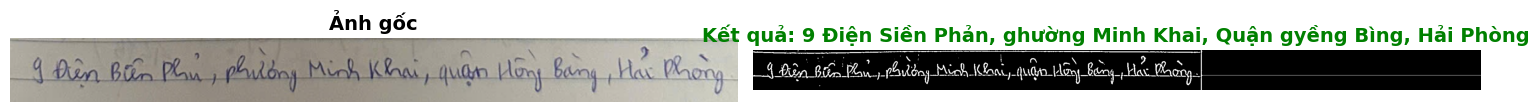

In [138]:
# Test on single image
image_path = "/content/drive/MyDrive/422001503103_Nhom9_NhanDienChuVietTayTiengViet/source_code/test3.png"

if os.path.exists(image_path):
    print(f"✓ Image found: {image_path}")
    
    # Predict
    predicted_text, processed_img = predict_single_image(
        model=act_model,
        image_path=image_path,
        char_list=char_list,
        resize_max_width=resize_max_width
    )
    
    # Display results
    print("\n" + "="*60)
    print("RECOGNITION RESULT:")
    print("="*60)
    print(f"Text: {predicted_text}")
    print("="*60)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(processed_img[:, :, 0], cmap='gray')
    axes[1].set_title(f"Result: {predicted_text}", fontsize=14, fontweight='bold', color='green')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"✗ Image not found: {image_path}")
    print("\nPlease:")
    print("1. Upload image to Google Drive (if using Colab)")
    print("2. Update 'image_path' variable with correct path")